<a href="https://colab.research.google.com/github/chunyuan0221/3rd-ML100days/blob/master/Day_084_overfitting_skill_compare_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.regularizers import l1, l2
def build_mlp(input_shape, output_neuron=10, regular_mode=0, reg_value=1e-1, drop_value=0, layer_neuron=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    regular_class = [None, l1, l2]
    input_layer = keras.layers.Input(shape=input_shape)
    for i, neuron in enumerate(layer_neuron):
        if i == 0:
            if regular_mode==0 and drop_value==0:
                x = keras.layers.BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i)(x)
            elif regular_mode>1 and drop_value==0:     # 做batch normalization + regularization
                x = keras.layers.BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i,
                                       kernel_regularizer=regular_class[regular_mode](reg_value))(x)
            elif regular_mode==0 and drop_value > 0:    # 做batch normalization + dropout
                x = keras.layers.BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i)(x)
                x = keras.layers.Dropout(drop_value)(x)
            else:                                      # 都做, batch normalization + regularization + dropout
                x = keras.layers.BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i,
                                       kernel_regularizer=regular_class[regular_mode](reg_value))(x)
                x = keras.layers.Dropout(drop_value)(x)
        else:                                          
            if regular_mode==0 and drop_value==0:        # 只做batch normalization
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i)(x)
            elif regular_mode>1 and drop_value==0:     # 做batch normalization + regularization
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i,
                                       kernel_regularizer=regular_class[regular_mode](reg_value))(x)
            elif regular_mode==0 and drop_value > 0:    # 做batch normalization + dropout
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i)(x)
                x = keras.layers.Dropout(drop_value)(x)
            else:                                      # 都做, batch normalization + regularization + dropout
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dense(units=neuron, 
                                       activation='relu',
                                       name='hidden_layer%s'%i,
                                       kernel_regularizer=regular_class[regular_mode](reg_value))(x)
                x = keras.layers.Dropout(drop_value)(x)
    
    out_layer = keras.layers.Dense(units=output_neuron, activation='softmax')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out_layer])                                   
    return model

In [0]:
"""Code Here
設定超參數
"""
EPOCH = 50
BATCH_SIZE = 256
LEARNING_RATE = 1e-2
regular_value = [1e-2, 1e-3, 1e-4   1e-1,]
dropout_value = [0, 0.15, 0.25, 0.35]

In [0]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}

# only BN                      / Reg=0, drop=0

# BN + Regular                 / Reg=1 or 2, drop=0

# BN + Dropout                 / Reg=0, drop>0

# BN + Regular + Dropout       / Reg=1 or 2, drop>0


# Regularization模式
reg_tag = {0:'off', 1:'L1', 2:'L2'}

# dropout不設定，因為設定為只要大於0就可以做dropout
# 0代表不做、1代表L1、2代表L2
regular_class = [0, 1, 2]

for i, drop in enumerate(dropout_value):
    for j in regular_class:
        keras.backend.clear_session()
        print("Experiment with BN + regular=%s + dropout=%s" %(reg_tag[j], drop))
        model = build_mlp(x_train.shape[1:], regular_mode=j, drop_value=drop)
        model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x_train, y_train,
                  epochs=EPOCH,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test, y_test),
                  shuffle=True)

        results['BN_reg=%s_drop=%s' %(reg_tag[j], drop)]=dict(train_loss=model.history.history['loss'],
                                                              valid_loss=model.history.history['val_loss'],
                                                              train_acc=model.history.history['acc'],
                                                              valid_acc=model.history.history['val_acc'])

Experiment with BN + regular=off + dropout=0
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 50us/step - loss: 1.9272 - acc: 0.3225 - val_loss: 1.7138 - val_acc: 0.4005
Epoch 2/30
50000/50000 [==============================] - 2s 40us/step - loss: 1.6177 - acc: 0.4319 - val_loss: 1.6059 - val_acc: 0.4395
Epoch 3/30
50000/50000 [==============================] - 2s 39us/step - loss: 1.5006 - acc: 0.4747 - val_loss: 1.5459 - val_acc: 0.4614
Epoch 4/30
50000/50000 [==============================] - 2s 39us/step - loss: 1.4226 - acc: 0.5029 - val_loss: 1.5060 - val_acc: 0.4684
Epoch 5/30
50000/50000 [==============================] - 2s 39us/step - loss: 1.3578 - acc: 0.5281 - val_loss: 1.4781 - val_acc: 0.4790
Epoch 6/30
50000/50000 [==============================] - 2s 40us/step - loss: 1.3027 - acc: 0.5477 - val_loss: 1.4607 - val_acc: 0.4854
Epoch 7/30
50000/50000 [==============================] - 2s 39us/step - loss: 1.25

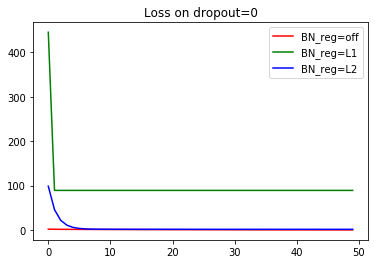

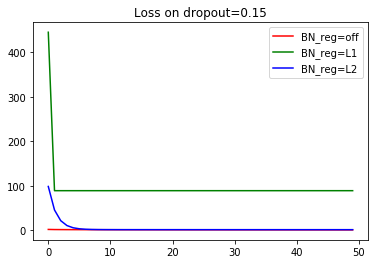

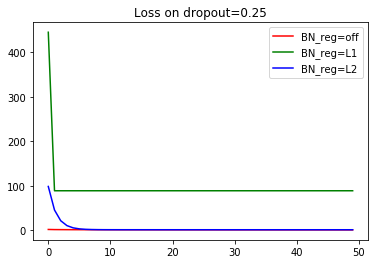

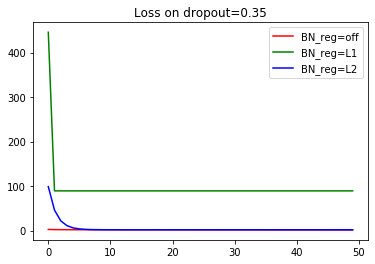

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

colorbar = ['r', 'g', 'b', 'y', 'm']
for i, drop in enumerate(dropout_value):
    for j in regular_class:
        #plt.figure(figsize=(8, 6))
        plt.plot(results['BN_reg=%s_drop=%s' %(reg_tag[j], drop)]['train_loss'], '-', color=colorbar[j], label='BN_reg=%s'%reg_tag[j])
    plt.title('Loss on dropout=%s' %drop)
    plt.legend()
    plt.show()

### Result
***
- 經過前面幾天的學習，我們知道BatchNormalization在預防overfitting上有很好的表現。因此，我們進行了幾種組合來測試哪種組合在模型預測上有好的表現，主要對象有這3種:BatchNormalization、Regularization、Dropout。
- 組合邏輯:每次執行都會有BatchNormalization和Dropout，但Dropout的參數若為0則不執行Dropout，單純只做BatchNormalization；而Regularization則會有L1和L2兩種。

![alt text](https://drive.google.com/uc?id=15GTD-wGg5fr5IEQGy3vdGg1ltC31Dl6Q)

- 最後，我們在這4張圖可以觀察到幾點:
    1. 只做BatchNormalization和做BatchNormalization + Dropout的效果似乎沒什麼變化(圖1~圖4 紅線)。
    2. 我們發現加入Regularization L2，不管有沒有Dropout都會讓初始的Loss特別大，但最後仍能收斂的和紅色線一樣低。
    3. 但在BatchNormalization搭配L1時(一樣不管有沒有Dropout)，會讓初始的Loss變得更大，而且無法收斂像紅線、藍線一樣低。

In [23]:
results = {}
# Regularization模式
reg_tag = {0:'off', 1:'L1', 2:'L2'}

# dropout不設定，因為設定為只要大於0就可以做dropout
# 0代表不做、1代表L1、2代表L2
regular_class = [0, 1, 2]

for i, drop in enumerate(dropout_value):
    keras.backend.clear_session()
    print("Experiment with BN + dropout=%s" %drop)
    model = build_mlp(x_train.shape[1:], drop_value=drop)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True)

    results['BN_drop=%s' %drop]=dict(train_loss=model.history.history['loss'],
                                     valid_loss=model.history.history['val_loss'],
                                     train_acc=model.history.history['acc'],
                                     valid_acc=model.history.history['val_acc'])

Experiment with BN + dropout=0
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 55us/step - loss: 1.9032 - acc: 0.3305 - val_loss: 1.6984 - val_acc: 0.3972
Epoch 2/30
50000/50000 [==============================] - 2s 43us/step - loss: 1.6040 - acc: 0.4349 - val_loss: 1.5962 - val_acc: 0.4338
Epoch 3/30
50000/50000 [==============================] - 2s 43us/step - loss: 1.4952 - acc: 0.4760 - val_loss: 1.5442 - val_acc: 0.4492
Epoch 4/30
50000/50000 [==============================] - 2s 44us/step - loss: 1.4186 - acc: 0.5010 - val_loss: 1.5066 - val_acc: 0.4638
Epoch 5/30
50000/50000 [==============================] - 2s 44us/step - loss: 1.3552 - acc: 0.5257 - val_loss: 1.4786 - val_acc: 0.4713
Epoch 6/30
50000/50000 [==============================] - 2s 44us/step - loss: 1.3003 - acc: 0.5475 - val_loss: 1.4562 - val_acc: 0.4842
Epoch 7/30
50000/50000 [==============================] - 2s 44us/step - loss: 1.2519 - acc: 0.56

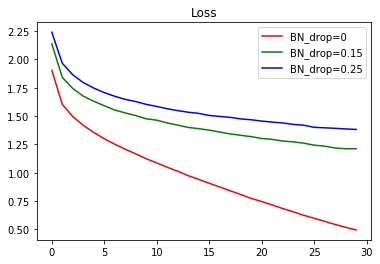

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

colorbar = ['r', 'g', 'b', 'y', 'm']
for i, drop in enumerate(dropout_value):
    plt.plot(results['BN_drop=%s' % drop]['train_loss'], '-', color=colorbar[i], label='BN_drop=%s'%drop)
plt.title('Loss')
plt.legend()
plt.show()

- 最後最後，我們去觀察那條被壓縮很低的BatchNormalization與Dropout結合的狀況:
  1. 可以看到只做BatchNormalization的效果就已經很好，不需要再搭配其他的組合
  